# Map 5 - Folds and unconformity
This map is from Bennison et al. (2011). It contains folds and an unconformity. First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

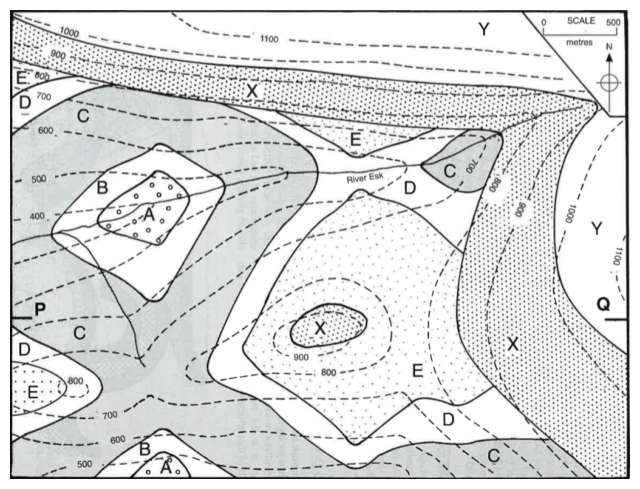

In [2]:
# Display map image
img = mpimg.imread("map5.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

In [4]:
# Read the topographic contours
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,29.51,1804.96,400,POINT (29.50900 1804.95600)
1,94.51,1811.87,400,POINT (94.50600 1811.87100)
2,152.48,1821.77,400,POINT (152.48100 1821.76500)
3,238.68,1833.15,400,POINT (238.68200 1833.14800)
4,323.14,1844.45,400,POINT (323.13700 1844.44900)


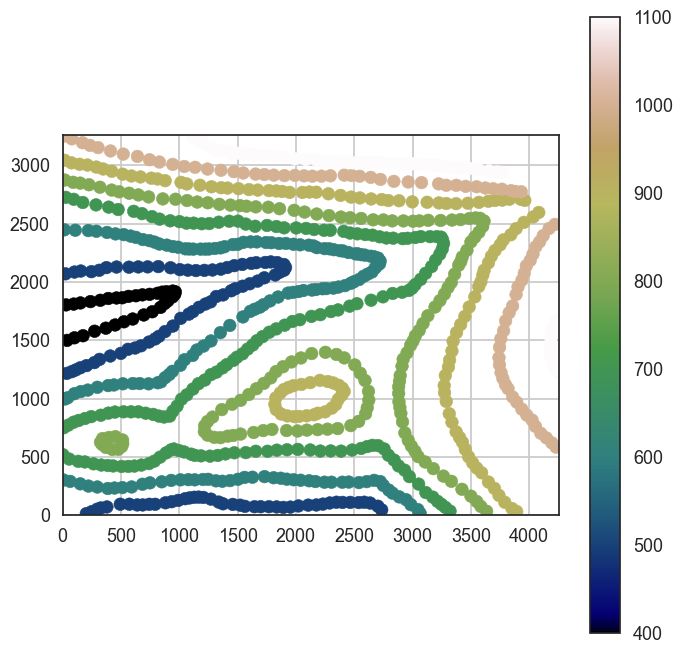

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True)
ax.set_ylim((0,3265))
ax.set_xlim((0,4252))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

In [6]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

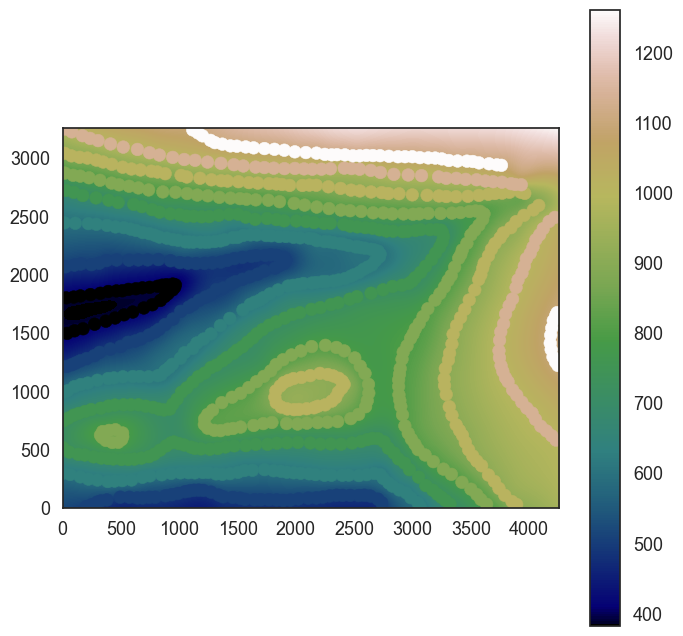

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth")
im = ax.imshow(topo_raster, origin="lower", extent=[0, 4252, 0, 3265], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map5.tif", 
                       extent=[0, 4252, 0, 3265], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map5.tif")

## 2. Stratigraphic boundaries or units' contacts

In [10]:
# Read the contacts. These are the bases of the units
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,557.85,2797.43,X,POINT (557.84700 2797.42600)
1,2712.66,2462.98,X,POINT (2712.66400 2462.97800)
2,3098.05,1454.49,X,POINT (3098.05000 1454.49500)
3,2207.05,937.43,X,POINT (2207.05500 937.43200)
4,2151.63,1210.60,X,POINT (2151.62700 1210.60000)


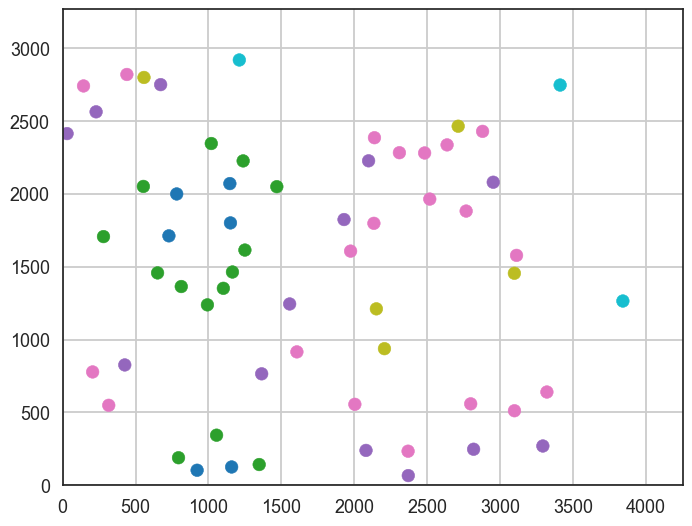

In [11]:
# Plot the points on the contacts
fig, ax = plt.subplots(1, figsize=(8, 8))
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,3265))
ax.set_xlim((0,4252))
ax.grid();

In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,557.85,2797.43,X,POINT (557.84700 2797.42600),818.22
1,2712.66,2462.98,X,POINT (2712.66400 2462.97800),746.89
2,3098.05,1454.49,X,POINT (3098.05000 1454.49500),819.33
3,2207.05,937.43,X,POINT (2207.05500 937.43200),910.74
4,2151.63,1210.60,X,POINT (2151.62700 1210.60000),876.80


### Strike lines

In [13]:
# Read the strike lines 
# In comparison to maps 1-4, this is a more complex structure, so we need more strike lines
gdf = df_to_gdf(os.path.join("strike_lines", "strike_lines.txt"), sep="\t")
gdf.head()

,X,Y,Z,formation,id,geometry
0,3722.82,2697.02,900,X,1,POINT (3722.81900 2697.02000)
1,4033.66,2567.36,900,X,1,POINT (4033.66000 2567.36200)
2,3757.64,1529.48,1000,X,2,POINT (3757.64500 1529.48300)
3,3.25,3239.03,1000,X,2,POINT (3.25000 3239.03100)
4,2766.61,532.12,700,E1,3,POINT (2766.60700 532.11700)


In [14]:
# Convert the points into strike lines
# base of X
linestring_gdf_X = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "X"])
# eastern fold, eastern flank, base of E
linestring_gdf_E1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "E1"])
# eastern fold, western flank, base of E
linestring_gdf_E2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "E2"])
# western fold, western flank, base of C
linestring_gdf_C = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "C"])
# western fold, eastern flank, base of D
linestring_gdf_D1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "D1"])
# western fold, western flank, base of D
linestring_gdf_D2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf["formation"] == "D2"])

In [15]:
# Check that the strike lines are valid
print("X\n", linestring_gdf_X.is_valid)
print("E1\n", linestring_gdf_E1.is_valid)
print("E2\n", linestring_gdf_E2.is_valid)
print("C\n", linestring_gdf_C.is_valid)
print("D1\n", linestring_gdf_D1.is_valid)
print("D2\n", linestring_gdf_D2.is_valid)

X
 0    True
1    True
dtype: bool
E1
 0    True
1    True
dtype: bool
E2
 0    True
1    True
dtype: bool
C
 0    True
1    True
dtype: bool
D1
 0    True
1    True
dtype: bool
D2
 0    True
1    True
dtype: bool


In [16]:
# Calculate orientations
orientations_X = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_X)
orientations_E1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_E1)
orientations_E2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_E2)
orientations_C = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_C)
orientations_D1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_D1)
orientations_D2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_D2)
# print orientations
print(f"X dip = {orientations_X.iloc[0,0]:.2f}, azimuth = {orientations_X.iloc[0,1]:.2f}")
print(f"E1 dip = {orientations_E1.iloc[0,0]:.2f}, azimuth = {orientations_E1.iloc[0,1]:.2f}")
print(f"E2 dip = {orientations_E2.iloc[0,0]:.2f}, azimuth = {orientations_E2.iloc[0,1]:.2f}")
print(f"C dip = {orientations_C.iloc[0,0]:.2f}, azimuth = {orientations_C.iloc[0,1]:.2f}")
print(f"D1 dip = {orientations_D1.iloc[0,0]:.2f}, azimuth = {orientations_D1.iloc[0,1]:.2f}")
print(f"D2 dip = {orientations_D2.iloc[0,0]:.2f}, azimuth = {orientations_D2.iloc[0,1]:.2f}")

X dip = 5.45, azimuth = 24.47
E1 dip = 19.49, azimuth = 270.14
E2 dip = 20.47, azimuth = 90.57
C dip = 19.26, azimuth = 268.42
D1 dip = 20.73, azimuth = 90.82
D2 dip = 18.84, azimuth = 270.81


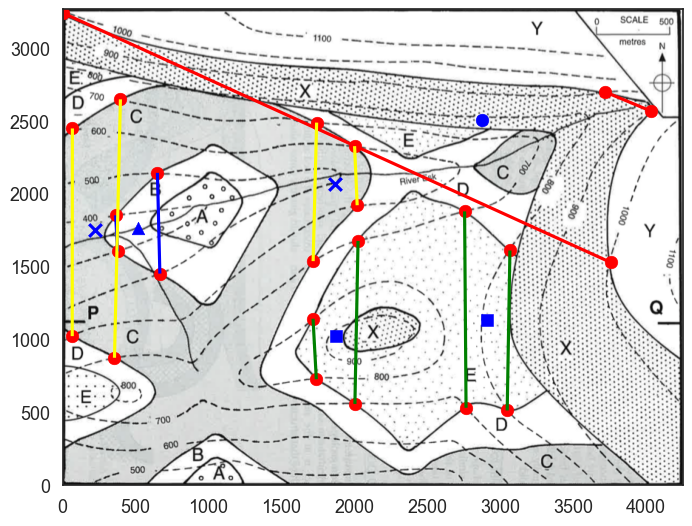

In [17]:
# Plot all this information on the map, so we can better understand this structure
fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.imshow(img, extent=[0, 4252, 0, 3265], cmap="gray")
# plot points
gdf.plot(ax=ax, aspect="equal", color="red")
# plot strike lines
# base of X
linestring_gdf_X.plot(ax=ax, aspect="equal", color="red")
orientations_X.plot(ax=ax, aspect="equal", color="blue", marker="o")
# eastern fold, eastern flank, base of E
linestring_gdf_E1.plot(ax=ax, aspect="equal", color="green")
orientations_E1.plot(ax=ax, aspect="equal", color="blue", marker="s")
# eastern fold, western flank, base of E
linestring_gdf_E2.plot(ax=ax, aspect="equal", color="green")
orientations_E2.plot(ax=ax, aspect="equal", color="blue", marker="s")
# western fold, western flank, base of C
linestring_gdf_C.plot(ax=ax, aspect="equal", color="blue")
orientations_C.plot(ax=ax, aspect="equal", color="blue", marker="^")
# western fold, eastern flank, base of D
linestring_gdf_D1.plot(ax=ax, aspect="equal", color="yellow")
orientations_D1.plot(ax=ax, aspect="equal", color="blue", marker="x")
# western fold, western flank, base of D
linestring_gdf_D2.plot(ax=ax, aspect="equal", color="yellow")
orientations_D2.plot(ax=ax, aspect="equal", color="blue", marker="x");

So, from the orientations derived from the strike lines, units A (oldest) to E are folded into an anticline (west) syncline (east) pair, trending N-S. A outcrops at the core of the anticline, while E outcrops at the core of the syncline. The dips of the folds limbs are 19-20 degrees. The base of X is an unconformity dipping 5 degrees to the NE. Units X and Y lie unconformably over folded units A-E. 

In [18]:
# Merge orientations
orientations = pd.concat([orientations_X, orientations_E1,orientations_E2,orientations_C,orientations_D1,orientations_D2]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.45,24.47,950.00,POINT (2879.34350 2508.22400),1.00,2879.34,2508.22,X
1,0,19.49,270.14,750.00,POINT (2909.89575 1133.86275),1.00,2909.90,1133.86,E1
2,0,20.47,90.57,750.00,POINT (1871.80100 1026.25625),1.00,1871.80,1026.26,E2
3,0,19.26,268.42,450.00,POINT (514.31075 1762.88750),1.00,514.31,1762.89,C
4,0,20.73,90.82,650.00,POINT (1870.49225 2068.26100),1.00,1870.49,2068.26,D1


In [19]:
# Rename the orientations correctly
orientations["formation"] = ["X", "E", "E", "C", "D","D"]
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.45,24.47,950.00,POINT (2879.34350 2508.22400),1.00,2879.34,2508.22,X
1,0,19.49,270.14,750.00,POINT (2909.89575 1133.86275),1.00,2909.90,1133.86,E
2,0,20.47,90.57,750.00,POINT (1871.80100 1026.25625),1.00,1871.80,1026.26,E
3,0,19.26,268.42,450.00,POINT (514.31075 1762.88750),1.00,514.31,1762.89,C
4,0,20.73,90.82,650.00,POINT (1870.49225 2068.26100),1.00,1870.49,2068.26,D


## 3. Construction of the model in GemPy

In [20]:
# Create a geomodel object called model5
geo_model = gp.create_model("model5")

In [21]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 4252, 0, 3265, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [22]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,X,Default series,1,#015482,1
1,Y,Default series,2,#9f0052,2
2,E,Default series,3,#ffbe00,3
3,D,Default series,4,#728f02,4
4,C,Default series,5,#443988,5
5,B,Default series,6,#ff3f20,6


In [23]:
# The base of the lowermost unit A does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("A")

# The units are divided into 2 series
# Strata1 = units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model, {"Strata1": ("Y", "X"),"Strata2": ("E","D", "C","B","A"),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
0,X,Strata1,1,#015482,1
1,Y,Strata1,2,#9f0052,2
2,E,Strata2,1,#ffbe00,3
3,D,Strata2,2,#728f02,4
4,C,Strata2,3,#443988,5
5,B,Strata2,4,#ff3f20,6
6,A,Strata2,5,#5DA629,7


In [24]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,X,Strata1,1,False,False,True,True,#015482,NaN,NaN,NaN,1,5,1
1,Y,Strata1,2,False,False,True,True,#9f0052,NaN,NaN,NaN,2,3,0
2,E,Strata2,1,False,False,True,True,#ffbe00,NaN,NaN,NaN,3,20,2
3,D,Strata2,2,False,False,True,True,#728f02,NaN,NaN,NaN,4,13,2
4,C,Strata2,3,False,False,True,True,#443988,NaN,NaN,NaN,5,14,1
5,B,Strata2,4,False,False,True,True,#ff3f20,NaN,NaN,NaN,6,6,0
6,A,Strata2,5,True,False,True,True,#5DA629,NaN,NaN,NaN,7,0,0


In [25]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map5.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [26]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [27]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer="fast_compile");

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             5453.41
$C_o$           708088.79
drift equations    [3, 3]


In [28]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

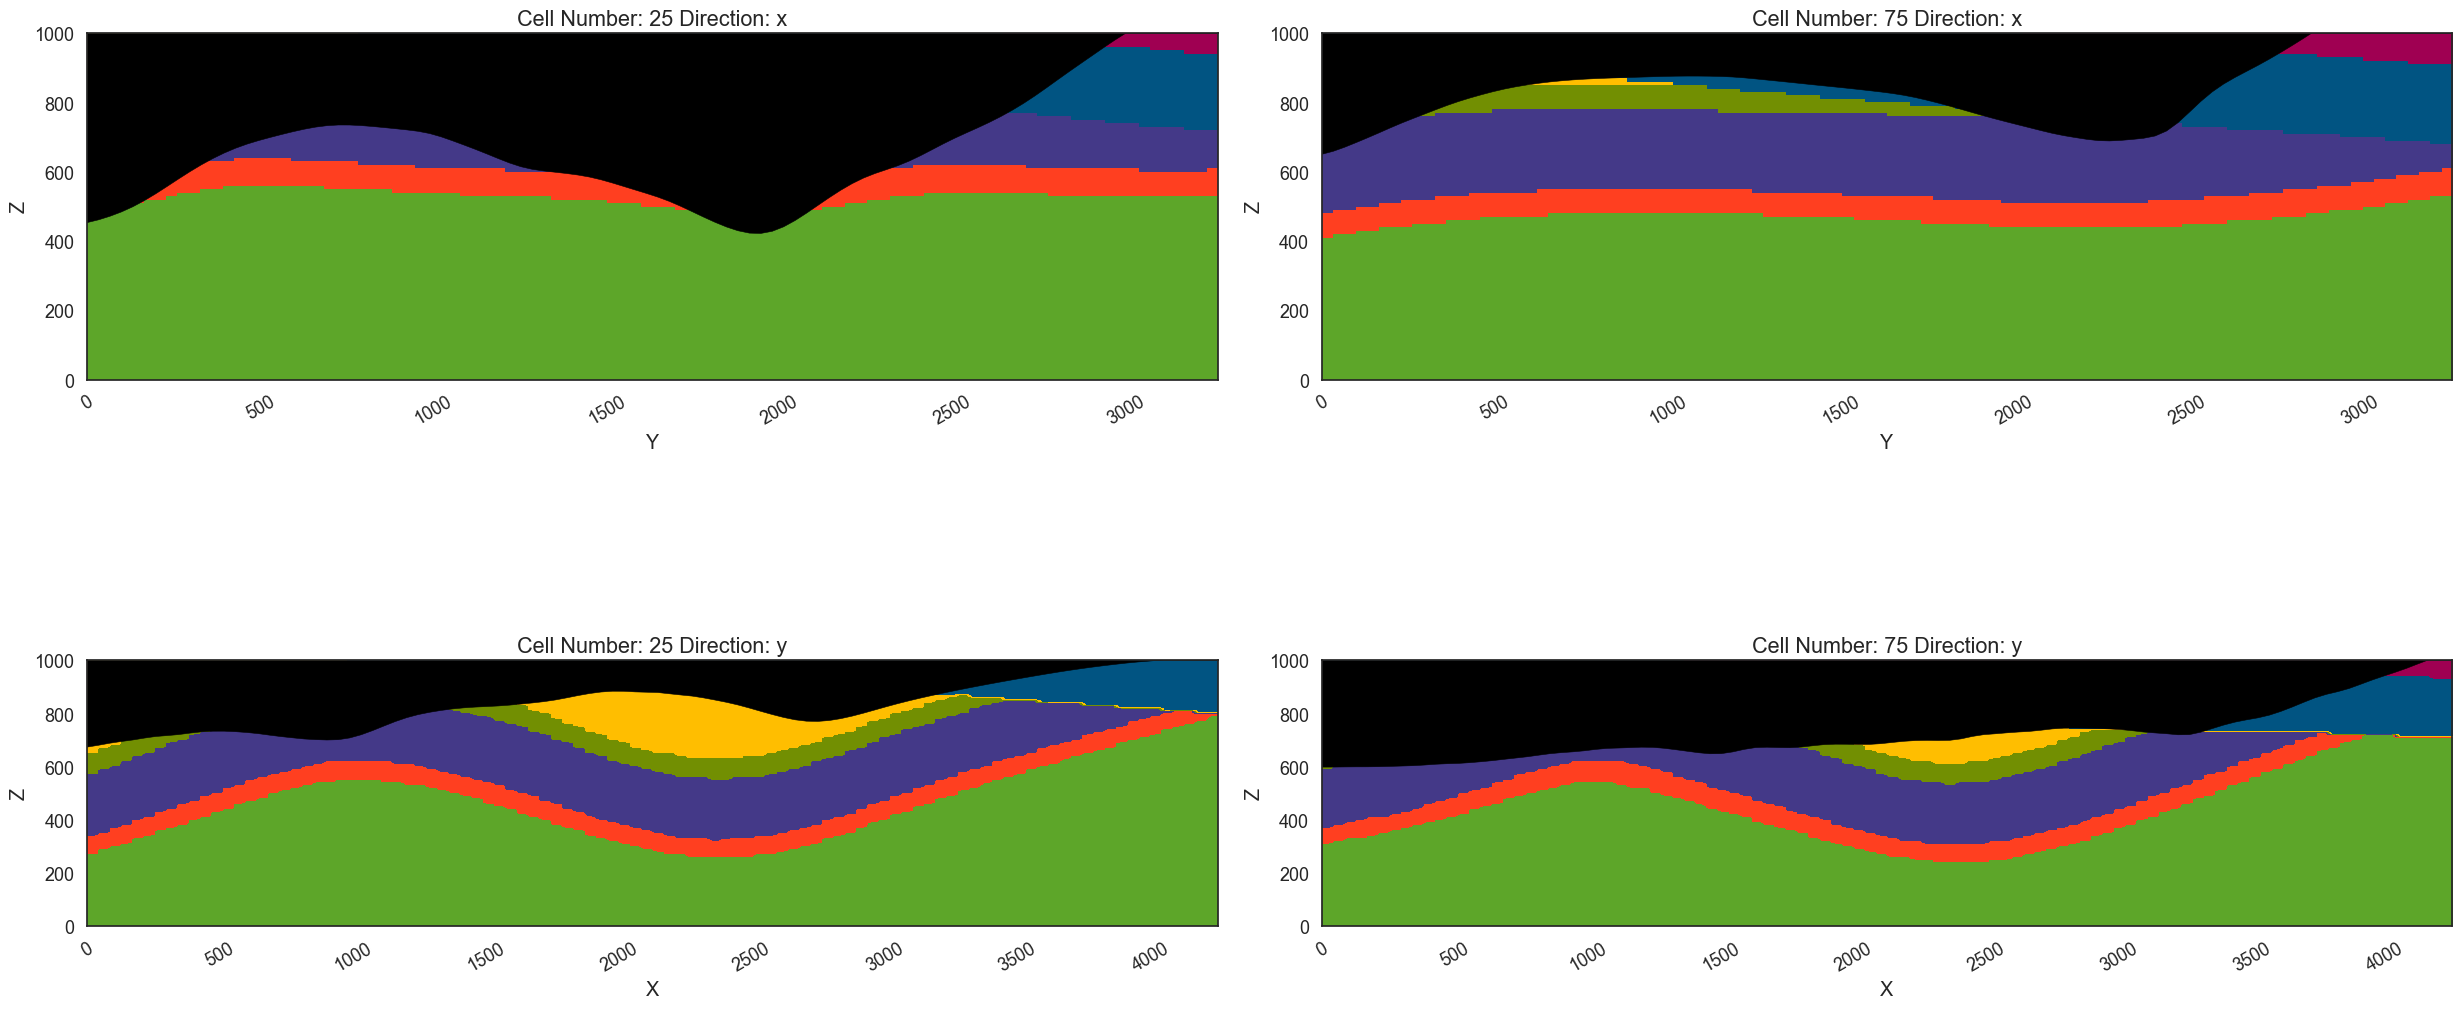

In [29]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [30]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);